<a href="https://colab.research.google.com/github/ys09123/EV_sales/blob/main/ev_sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Load and filter EV stock data

In [4]:
df = pd.read_csv('./EV.csv')

In [4]:
df.head(10)

,region,category,parameter,mode,powertrain,year,unit,value
0,Australia,Historical,EV sales,Cars,BEV,2011,Vehicles,49.00000
1,Australia,Historical,EV stock share,Cars,EV,2011,percent,0.00039
2,Australia,Historical,EV sales share,Cars,EV,2011,percent,0.00650
3,Australia,Historical,EV stock,Cars,BEV,2011,Vehicles,49.00000
4,Australia,Historical,EV stock,Cars,BEV,2012,Vehicles,220.00000
5,Australia,Historical,EV stock,Cars,PHEV,2012,Vehicles,80.00000
6,Australia,Historical,EV sales,Cars,PHEV,2012,Vehicles,80.00000
7,Australia,Historical,EV sales share,Cars,EV,2012,percent,0.03000
8,Australia,Historical,EV stock share,Cars,EV,2012,percent,0.00240
9,Australia,Historical,EV sales,Cars,BEV,2012,Vehicles,170.00000


In [ ]:
df['parameter'].unique()

array(['EV sales', 'EV stock share', 'EV sales share', 'EV stock',
       'Electricity demand', 'Oil displacement Mbd',
       'Oil displacement, million lge'], dtype=object)

In [ ]:
df.shape

(3798, 8)

In [ ]:
df.duplicated().sum()

np.int64(0)

In [ ]:
df.isnull().sum()

,0
region,0
category,0
parameter,0
mode,0
powertrain,0
year,0
unit,0
value,0


In [5]:
# Filter for EV stock data
df_ev_stock = df[df['parameter'] == 'EV stock']

In [6]:
# Select latest year
df_latest = df_ev_stock[df_ev_stock['year'] == df_ev_stock['year'].max()]

## Geocode Regions


In [7]:
from geopy.geocoders import Nominatim
import time

In [8]:
# Get unique regions
regions = df_latest['region'].unique()

In [9]:
df_coords = []
geolocator = Nominatim(user_agent="ev_locator")

for region in regions:
  try:
    location = geolocator.geocode(region)
    if location:
      df_coords.append({
          'region' : region,
          'lat' : location.latitude,
          'lon' : location.longitude
      })
    else:
      df_coords.append({
          'region' : region,
          'lat' : None,
          'lon' : None
      })
      time.sleep(1)

  except:
    df_coords.append({
        'region' : region,
        'lat' : None,
        'lon' : None
    })

In [10]:
# Merge with EV stock
df_coords = pd.DataFrame(df_coords)
df_map = df_latest.merge(df_coords, on='region')

## Visualize EV stock with Folium

In [11]:
import folium

In [12]:
map_ev = folium.Map(location=[20, 0], zoom_start=2)

for _, row in df_map.iterrows():
  if pd.notnull(row['lat']) and pd.notnull(row['lon']):
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=max(row['value'] / 1e6, 2),
        popup=f"{row['region']}: {int(row['value']):,} EVs",
        color='blue',
        fill=True,
        fill_opacity=0.6
    ).add_to(map_ev)

map_ev.save("ev_charging_map.html")

## Fetch Charging station data (OpenChargerMap)

In [13]:
import requests

#Fetch charger data by country
def get_charging_stations(country, max_results=100):
  url = "https://api.openchargemap.io/v3/poi/"
  params = {
      "output" : "json",
      "maxresults" : max_results,
      "compact" : True,
      "verbose" : False,
      "key" : "OCM-API-TEST",
      "country" : country
  }
  try:
    response = requests.get(url, params=params)
    if response.status_code == 200:
      data = response.json()
      return [{
          "country" : country,
          "lat" : item["AddressInfo"]["Latitude"],
          "lon" : item["AddressInfo"]["Longitude"],
          "name" : item["AddressInfo"]["Title"]
      } for item in data]

    else:
      return []

  except:
    return[]

# Countries to check
top_countries = ['United States', 'China', 'Germany', 'United Kingdom', 'France']
chargers_data = []

for country in top_countries:
  chargers_data += get_charging_stations(country, max_results=200)
  time.sleep(1)

df_chargers = pd.DataFrame(chargers_data)



## Visualize chargers on EV stock map

In [14]:
# Add charger markers to map
for _, row in df_chargers.iterrows():
  folium.Marker(
      location=[row['lat'], row['lon']],
      popup=row['title'],
      icon=folium.Icon(color='green', icon='bolt', prefix='fa')
  ).add_to(map_ev)

map_ev.save("ev_stock_with_chargers.html")

## Clustering Underserved Regions

In [15]:
from sklearn.cluster import KMeans

In [16]:
# Count chargers per country
# ✅ Validate charger data before grouping
if df_chargers.empty or 'country' not in df_chargers.columns:
    print("⚠️ No charger data or 'country' field missing. Check API responses.")
    charger_counts = pd.DataFrame(columns=['country', 'num_chargers'])
else:
    charger_counts = df_chargers.groupby('country').size().reset_index(name='num_chargers')

#Merge EV stock with charger counts
df_map['country'] = df_map['region']
df_cluster = df_map.merge(charger_counts, on='country', how='left').fillna(0)
df_cluster['charger_density'] = df_cluster['num_chargers'] / (df_cluster['value'] + 1)

# Apply Clustering
X = df_cluster[['value', 'num_chargers']]
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
df_cluster['cluster'] = kmeans.labels_

⚠️ No charger data or 'country' field missing. Check API responses.


<ipython-input-16-de190355c481>:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_cluster = df_map.merge(charger_counts, on='country', how='left').fillna(0)


## Voronoi Diagram

In [17]:
from scipy.spatial import Voronoi, voronoi_plot_2d

Text(0.5, 1.0, 'Voronoi Diagram of EV clustering')

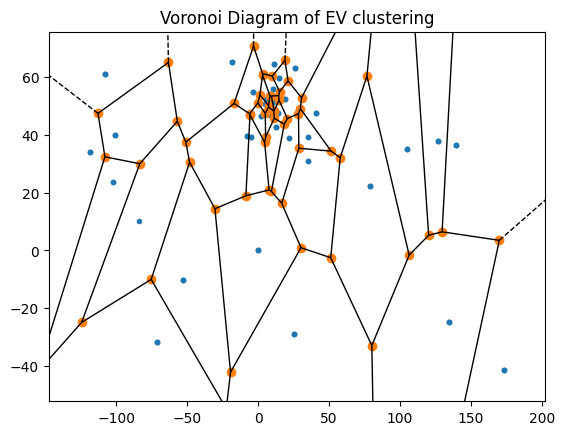

In [18]:
# Plot Voronoi
df_vor = df_cluster.dropna(subset=['lat', 'lon'])
coords = df_vor[['lon', 'lat']].values
vor = Voronoi(coords)
fig = voronoi_plot_2d(vor)
plt.title("Voronoi Diagram of EV clustering")

In [19]:
from mpl_toolkits.basemap import Basemap

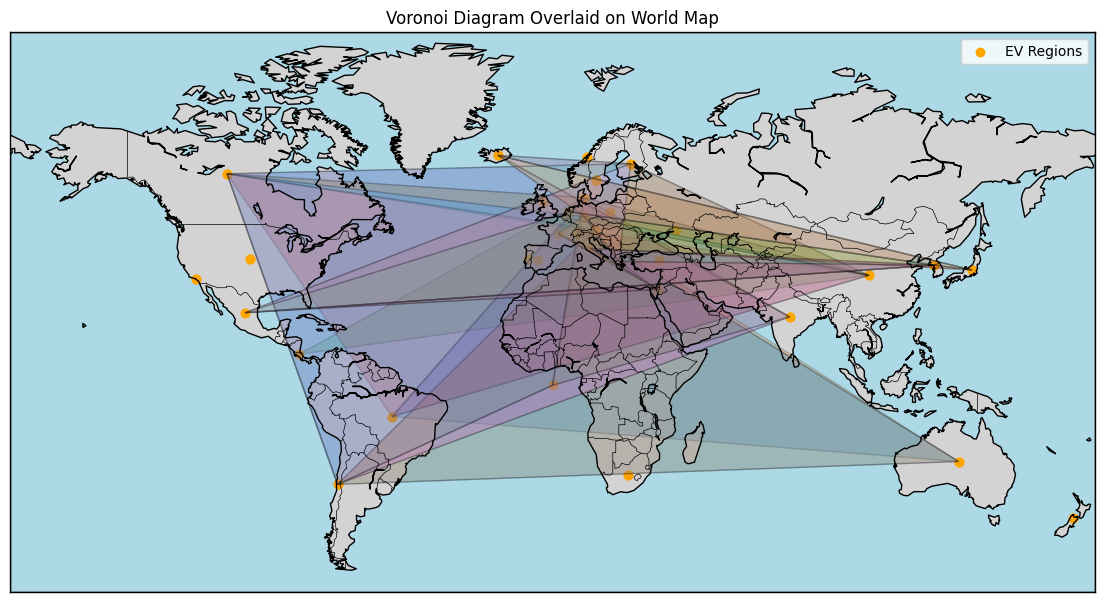

In [23]:
# Filter out rows with missing coordinates
df_vor = df_cluster.dropna(subset=['lat', 'lon'])
coords = df_vor[['lon', 'lat']].values

# Compute Voronoi diagram
vor = Voronoi(coords)

# Plot
fig = plt.figure(figsize=(14, 8))
m = Basemap(projection='mill', llcrnrlat=-60, urcrnrlat=85, llcrnrlon=-180, urcrnrlon=180, resolution='c')
m.drawcoastlines()
m.drawcountries()
m.drawmapboundary(fill_color='lightblue')
m.fillcontinents(color='lightgray', lake_color='lightblue')

# Convert lat/lon to map x/y
mapped_coords = [m(x, y) for x, y in coords]

# Plot Voronoi points
x, y = zip(*mapped_coords)
plt.scatter(x, y, c='orange', label='EV Regions')

# Draw Voronoi regions
for region in vor.regions:
    if not -1 in region and len(region) > 0:
        polygon = [mapped_coords[i] for i in region if i < len(mapped_coords)]
        if len(polygon) >= 3:
            plt.fill(*zip(*polygon), alpha=0.2, edgecolor='black')

plt.title("Voronoi Diagram Overlaid on World Map")
plt.legend()

In [29]:
!git config --global user.email "shawb278@gmail.com"
!git config --global user.name "ys09123"

In [30]:
!git clone https://github.com/ys09123/EV_sales.git

Cloning into 'EV_sales'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (3/3), done.
